# ACTIVITY: LOST IN TRANSLATION

**ACTIVITY DESCRIPTION: At the end of this activity, the learner will be able to compare different methodologies for classification of non-English texts**

**WHAT YOU SHOULD FOCUS ON: Use and compare different methodologies for a similar task**

One (very big) problem of natural language processing is that most data *corpi* are in English, but most people in the world are not English speakers. There are languages that have few speakers, or that have few available documents for training. This is especially true in the context of large-scale models, which are known for being *data hungry*, that is, they require *a lot* of data to be adequately trained.

There are essentially two methods to deal with non-English texts:

1. Translate the text to English and then act on the translation
1. Train language models in different languages

Nowadays, translation is relatively easy to perform using the `argostranslate` package in Python:

In [11]:
import os

os.environ["ARGOS_DEVICE_TYPE"] = "cpu" # or "cpu"

import argostranslate.package
import argostranslate.translate

# First, we need to configure the translator:
def _configure_argos(from_code="pt", to_code="en"):
    argostranslate.package.update_package_index()
    available_packages = argostranslate.package.get_available_packages()
    available_package = list(
        filter(lambda x: x.from_code == from_code and x.to_code == to_code,
               available_packages))[0]
    download_path = available_package.download()
    argostranslate.package.install_from_path(download_path)
    installed_languages = argostranslate.translate.get_installed_languages()
    from_lang = list(filter(lambda x: x.code == from_code,
                            installed_languages))[0]
    to_lang = list(filter(lambda x: x.code == to_code, installed_languages))[0]
    translation = from_lang.get_translation(to_lang)
    return translation

translator = _configure_argos('pt', 'en')

In [12]:
translator.translate("Olá, como você está?")  # "Hello, how are you?"

'Hi, how are you?'

In [13]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-multilingual-uncased')

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


In [14]:
print(unmasker("I walk this lonely [MASK], the only one that I have ever known!")[0]['sequence'])
print(unmasker("Eu caminhei sozinho pela [MASK], falei com as estrelas e com a Lua")[0]['sequence'])

i walk this lonely road, the only one that i have ever known!
eu caminhei sozinho pela terra, falei com as estrelas e com a lua


# Exercise

Compare three different approaches to tackle the classification problem for texts in Portuguese. For each problem, make a learning curve, that is, make random samples of the training dataset with different sizes.

1. Perform classification directly in Portuguese, using a Bag-of-Words approach
1. Classify texts directly in Portuguese using multilingual BERT
1. Translate texts to English and then use the usual BERT


In [15]:
import kagglehub
from pathlib import Path
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("jvbeltra/sentiment-analysis-pt-br-stock-market-tweets")
path = Path(path)
df = pd.read_csv(path / "analise_sentimentos_ibovespa_twitter.csv")
df.head()

,post_id,text,created_at,finbertptbr_prediction,gpt_prediction,real_sentiment
0,1818246570069934451,"a partir desse cálculo, para cada empresa do i...",2024-07-30T08:25:38.000000Z,NEUTRAL,NEUTRAL,NEUTRAL
1,1818251106570395982,ibovespa reage às entrelinhas do relatório de ...,2024-07-30T08:43:39.000000Z,NEUTRAL,NEUTRAL,NEUTRAL
2,1818257465793765640,ibovespa em queda de olho na reunião do copom,2024-07-30T09:08:56.000000Z,NEGATIVE,NEGATIVE,NEGATIVE
3,1818262436144669087,esquenta dos mercados \nbom dia!\no ibovespa a...,2024-07-30T09:28:41.000000Z,POSITIVE,NEUTRAL,NEUTRAL
4,1818262819063660642,ibovespa futuro cai na expectativa pelo 1º dia...,2024-07-30T09:30:12.000000Z,NEGATIVE,NEGATIVE,NEGATIVE


## First Approach: Bag-of-Words

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test_bow = train_test_split(df['text'], df['real_sentiment'], test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred_bow = pipeline.predict(X_test)
print(classification_report(y_test_bow, y_pred_bow))

              precision    recall  f1-score   support

    NEGATIVE       0.77      0.19      0.30        53
     NEUTRAL       0.61      0.74      0.67        98
    POSITIVE       0.71      0.83      0.76       107

    accuracy                           0.67       258
   macro avg       0.70      0.59      0.58       258
weighted avg       0.68      0.67      0.63       258



## Second Approach: Multilingual BERT

In [34]:
from transformers import BertTokenizer, BertModel
import numpy as np
from tqdm import tqdm

def get_embeddings(text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[0, 0, :]
    return cls_embedding

tokenizer_pt = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model_pt = BertModel.from_pretrained("bert-base-multilingual-uncased")

embeddings = []
for i in tqdm(range(len(df))):
    e = get_embeddings(df.iloc[i]['text'], model_pt, tokenizer_pt)
    embeddings.append(e.detach().numpy())
embeddings = np.array(embeddings)

np.save('bert_pt_embeddings.npy', embeddings)

100%|██████████| 1290/1290 [00:37<00:00, 34.41it/s]


In [35]:
embeddings_pt = np.load('bert_pt_embeddings.npy')

In [36]:
X_train, X_test, y_train, y_test = train_test_split(embeddings_pt, df['real_sentiment'], test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.42      0.21      0.28        53
     NEUTRAL       0.59      0.61      0.60        98
    POSITIVE       0.65      0.79      0.71       107

    accuracy                           0.60       258
   macro avg       0.55      0.53      0.53       258
weighted avg       0.58      0.60      0.58       258



## Third Approach: Translate to English and use classic BERT

In [37]:
# df['text_en'] = df['text'].apply(lambda x: translator.translate(x))

In [38]:
X_train, X_test, y_train, y_test_mbert = train_test_split(df['text_en'], df['real_sentiment'], test_size=0.2, random_state=42)

### Bag-of-Words

In [39]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred_mbert = pipeline.predict(X_test)
print(classification_report(y_test_mbert, y_pred_mbert))

              precision    recall  f1-score   support

    NEGATIVE       0.56      0.17      0.26        53
     NEUTRAL       0.60      0.74      0.66        98
    POSITIVE       0.72      0.80      0.76       107

    accuracy                           0.65       258
   macro avg       0.63      0.57      0.56       258
weighted avg       0.64      0.65      0.62       258



### Bert

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from transformers import BertTokenizer, BertModel

from sklearn.base import BaseEstimator, TransformerMixin
from transformers import BertTokenizer, BertModel
import numpy as np

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='bert-base-uncased', max_length=512):
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model     = BertModel.from_pretrained(model_name)

    def fit(self, X, y=None):
        return self

    def transform(self, texts):
        embeddings = []
        for text in texts:
            inputs = self.tokenizer(
                text,
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=self.max_length
            )
            outputs = self.model(**inputs)
            cls_emb = outputs.last_hidden_state[0, 0, :].detach().numpy()
            embeddings.append(cls_emb)
        return np.vstack(embeddings)


X_train, X_test, y_train, y_test_enbert = train_test_split(df['text_en'], df['real_sentiment'], test_size=0.2, random_state=42)
pipeline = Pipeline([
    ('bert', BertTransformer()),
    ('logreg', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred_enbert = pipeline.predict(X_test)
print(classification_report(y_test_enbert, y_pred_enbert))

              precision    recall  f1-score   support

    NEGATIVE       0.31      0.28      0.30        53
     NEUTRAL       0.57      0.64      0.61        98
    POSITIVE       0.67      0.63      0.65       107

    accuracy                           0.56       258
   macro avg       0.52      0.52      0.52       258
weighted avg       0.56      0.56      0.56       258



## Graphs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

KeyboardInterrupt: 

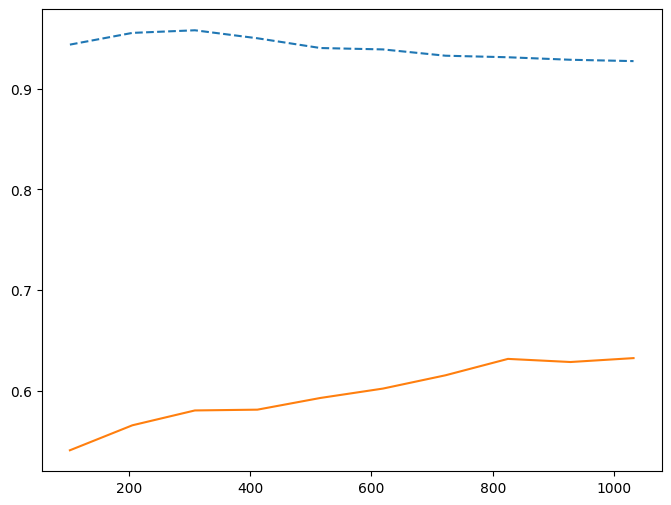

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Assuming you already have df['text'], df['text_en'], df['real_sentiment']
# and your translator, BertTransformer, etc.

# 1) Define three pipelines
pipeline_bow = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline_mbert = Pipeline([
    ('embed', BertTransformer(model_name='bert-base-multilingual-uncased')),
    ('clf',   LogisticRegression(max_iter=1000))
])

pipeline_enbert = Pipeline([
    ('embed', BertTransformer()),  # defaults to 'bert-base-uncased'
    ('clf',   LogisticRegression(max_iter=1000))
])


# 2) Prepare data
X_bow   = df['text']
X_mbert = df['text']    # multilingual BERT works on original Portuguese text
X_en    = df['text_en'] # translated text
y       = df['real_sentiment']

# 3) Helper to plot one learning curve
def plot_curve(estimator, X, y, label, ax):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y,
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy',
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    test_mean  = test_scores.mean(axis=1)
    ax.plot(train_sizes, train_mean, '--', label=f'{label} (train)')
    ax.plot(train_sizes, test_mean,  '-' , label=f'{label} (cv)')

# 4) Create the figure
fig, ax = plt.subplots(figsize=(8, 6))
plot_curve(pipeline_bow,   X_bow,   y, 'Bag-of-Words', ax)
plot_curve(pipeline_mbert, X_mbert, y, 'Multilingual BERT', ax)
plot_curve(pipeline_enbert, X_en,   y, 'Translate→BERT', ax)

ax.set_title('Learning Curves')
ax.set_xlabel('Training set size')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')
ax.grid(True)
plt.tight_layout()
plt.show()
